<a href="https://colab.research.google.com/github/jacelyntan880-os/jacelyn-2331055/blob/main/Fuzzy_Logic_ACC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install scikit-fuzzy --quiet

In [17]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
D = ctrl.Antecedent(np.arange(0, 121, 1), 'distance')
dV = ctrl.Antecedent(np.arange(-40, 41, 1), 'rel_speed')
S = ctrl.Antecedent(np.arange(-10, 11, 1), 'slope')
A = ctrl.Consequent(np.arange(-3.0, 3.01, 0.01), 'acceleration')

In [19]:
D['very_close'] = fuzz.trapmf(D.universe, [0, 0, 5, 10])
D['close']      = fuzz.trimf(D.universe, [5, 15, 30])
D['safe']       = fuzz.trimf(D.universe, [25, 40, 60])
D['far']        = fuzz.trimf(D.universe, [50, 70, 90])
D['very_far']   = fuzz.trapmf(D.universe, [80, 100, 120, 120])

In [20]:
dV['closing_fast'] = fuzz.trapmf(dV.universe, [-40, -40, -20, -10])
dV['closing']      = fuzz.trimf(dV.universe, [-15, -7, 0])
dV['zero']         = fuzz.trimf(dV.universe, [-2, 0, 2])
dV['opening']      = fuzz.trimf(dV.universe, [0, 7, 15])
dV['opening_fast'] = fuzz.trapmf(dV.universe, [10, 20, 40, 40])

In [21]:
S['downhill']    = fuzz.trapmf(S.universe, [-10, -10, -6, -3])
S['slight_down'] = fuzz.trimf(S.universe, [-5, -2, 0])
S['flat']        = fuzz.trimf(S.universe, [-1, 0, 1])
S['slight_up']   = fuzz.trimf(S.universe, [0, 2, 5])
S['uphill']      = fuzz.trapmf(S.universe, [3, 6, 10, 10])

In [22]:
A['strong_brake'] = fuzz.trapmf(A.universe, [-3.0, -3.0, -2.5, -1.5])
A['brake']        = fuzz.trimf(A.universe, [-2.0, -1.0, 0.0])
A['coast']        = fuzz.trimf(A.universe, [-0.5, 0.0, 0.5])
A['accel']        = fuzz.trimf(A.universe, [0.0, 1.0, 2.0])
A['strong_accel'] = fuzz.trapmf(A.universe, [1.5, 2.5, 3.0, 3.0])

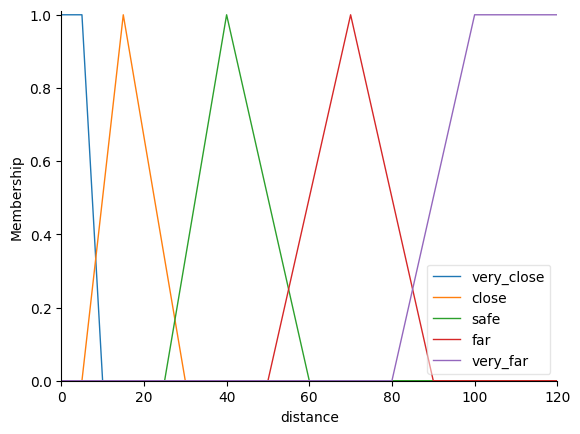

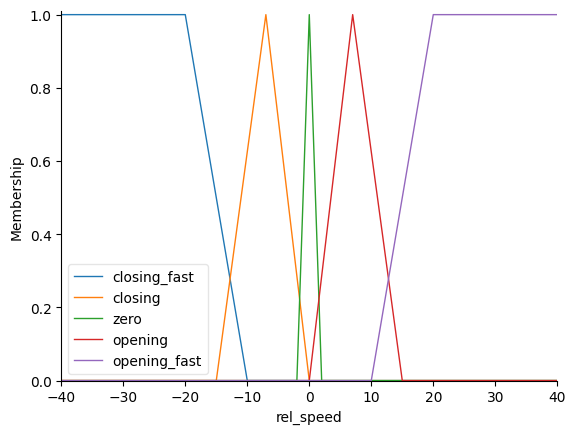

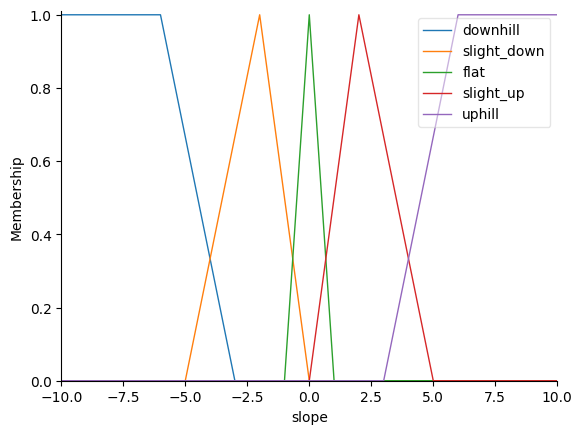

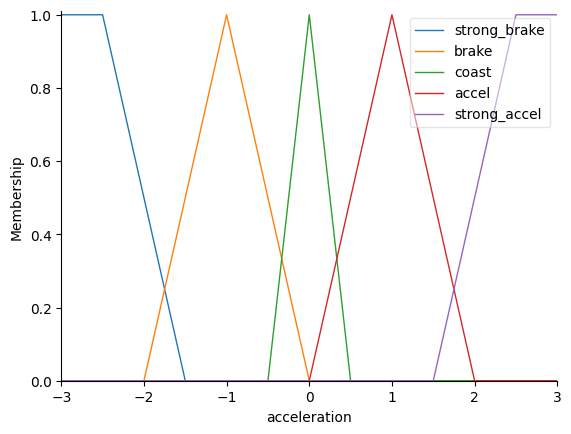

In [23]:
D.view(title="Distance membership")
dV.view(title="Relative speed membership")
S.view(title="Slope membership")
A.view(title="Acceleration membership")
plt.show()

In [24]:
rules = []

In [25]:
rules.append(ctrl.Rule(D['very_close'] | (D['close'] & dV['closing_fast']), A['strong_brake']))
rules.append(ctrl.Rule(D['close'] & dV['closing'], A['brake']))
rules.append(ctrl.Rule(D['safe'] & dV['zero'], A['coast']))
rules.append(ctrl.Rule(D['far'] & dV['opening'], A['accel']))
rules.append(ctrl.Rule(D['very_far'] & dV['opening_fast'], A['strong_accel']))
rules.append(ctrl.Rule(S['downhill'] & D['close'], A['brake']))
rules.append(ctrl.Rule(S['uphill'] & D['safe'], A['accel']))
rules.append(ctrl.Rule(D['close'] & S['slight_up'] & dV['opening'], A['coast']))
rules.append(ctrl.Rule(D['safe'] & dV['closing'], A['brake']))

In [26]:
rules.append(ctrl.Rule(D['far'] & dV['zero'] & S['flat'], A['coast']))
rules.append(ctrl.Rule(D['safe'] & dV['opening_fast'] & S['uphill'], A['accel']))

In [27]:
acc_ctrl = ctrl.ControlSystem(rules)
acc_sim = ctrl.ControlSystemSimulation(acc_ctrl)

In [28]:
scenarios = [
    {'distance': 8, 'rel_speed': -12, 'slope': 0},   # very close, we're closing fast -> strong brake
    {'distance': 35, 'rel_speed': -5, 'slope': 0},   # safe-ish but closing -> mild brake
    {'distance': 80, 'rel_speed': 5, 'slope': 0},    # far and other pulling away -> accelerate
    {'distance': 20, 'rel_speed': 0, 'slope': -6},   # close and downhill -> brake
    {'distance': 50, 'rel_speed': 10, 'slope': 4},   # safe, opening, uphill -> accel
]

results = []
for s in scenarios:
    acc_sim.input['distance'] = s['distance']
    acc_sim.input['rel_speed'] = s['rel_speed']
    acc_sim.input['slope'] = s['slope']
    acc_sim.compute()
    out = acc_sim.output['acceleration']
    results.append((s, out))
    print(f"Scenario {s} -> acceleration = {out:.3f} m/s^2")

Scenario {'distance': 8, 'rel_speed': -12, 'slope': 0} -> acceleration = -1.674 m/s^2
Scenario {'distance': 35, 'rel_speed': -5, 'slope': 0} -> acceleration = -1.000 m/s^2
Scenario {'distance': 80, 'rel_speed': 5, 'slope': 0} -> acceleration = 1.000 m/s^2
Scenario {'distance': 20, 'rel_speed': 0, 'slope': -6} -> acceleration = -1.000 m/s^2
Scenario {'distance': 50, 'rel_speed': 10, 'slope': 4} -> acceleration = 1.000 m/s^2


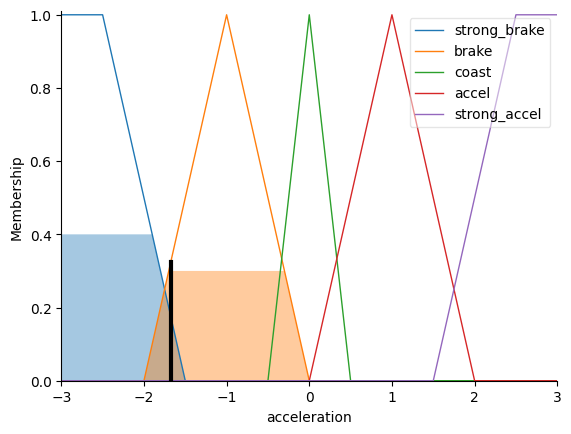

In [29]:
acc_sim.input['distance'] = scenarios[0]['distance']
acc_sim.input['rel_speed'] = scenarios[0]['rel_speed']
acc_sim.input['slope'] = scenarios[0]['slope']
acc_sim.compute()
A.view(sim=acc_sim)
plt.show()

In [30]:
print("\nEvaluation Summary:")
for s, out in results:
    reason = ""
    if out < -1.0:
        reason = "strong braking (safety)"
    elif out < -0.2:
        reason = "mild braking"
    elif out < 0.2:
        reason = "coasting / maintain speed"
    elif out < 1.5:
        reason = "gentle acceleration"
    else:
        reason = "strong acceleration"
    print(f"Input {s} -> accel {out:.3f} m/s^2 => {reason}")


Evaluation Summary:
Input {'distance': 8, 'rel_speed': -12, 'slope': 0} -> accel -1.674 m/s^2 => strong braking (safety)
Input {'distance': 35, 'rel_speed': -5, 'slope': 0} -> accel -1.000 m/s^2 => mild braking
Input {'distance': 80, 'rel_speed': 5, 'slope': 0} -> accel 1.000 m/s^2 => gentle acceleration
Input {'distance': 20, 'rel_speed': 0, 'slope': -6} -> accel -1.000 m/s^2 => mild braking
Input {'distance': 50, 'rel_speed': 10, 'slope': 4} -> accel 1.000 m/s^2 => gentle acceleration
